In [1]:
import numpy as np
import pandas as pd
import os, requests, zipfile, warnings, time, random
from io import BytesIO
import datetime
import tqdm
import concurrent.futures
from threading import Lock
warnings.filterwarnings('ignore')

In [2]:
test_url = 'http://data.gdeltproject.org/gdeltv2/20250219000000.gkg.csv.zip'
base_url = 'http://data.gdeltproject.org/gdeltv2/'

In [3]:
# GCAM sentiment variable dictionary
doc = pd.read_csv(r"..\Data\GCAM-MASTER-CODEBOOK.TXT",
        delimiter='\t',
        encoding='latin',
        low_memory=False,
        usecols=['Variable', 'Type', 'DimensionHumanName'],
    )
doc['new_name'] = doc['Variable'] + '; ' + doc['Type'] + '; ' + doc['DimensionHumanName']
doc_dict = doc.to_dict(orient='list')

In [4]:
def parse_data(data):
    df = pd.read_csv(
        data,
        delimiter='\t',
        encoding='latin',
        low_memory=False,
        header=None,
        usecols=[0, 1, 2, 3, 4, 7, 9, 13, 15, 17, 25, 26],
        names=[
            'GKGRECORDID',
            'V2.1DATE',
            'V2SOURCECOLLECTIONIDENTIFIER',
            'V2SOURCECOMMONNAME',
            'V2DOCUMENTIDENTIFIER',
            'V1THEMES',
            'V1LOCATIONS',
            'V1ORGANIZATIONS',
            'V1.5TONE',
            'V2GCAM',
            'V2.1TRANSLATIONINFO',
            'V2EXTRASXML'
        ]
    )
    return(df)

In [5]:
def download_unzip(url):
    """
    Downloads a zipped CSV file from the given URL, extracts the first file in the archive,
    and parses it into a pandas DataFrame using the parse_data function.

    Args:
        url (str): The URL to the .zip file containing the CSV.

    Returns:
        tuple: (DataFrame, status_code)
            DataFrame: The parsed data as a pandas DataFrame.
            status_code: The HTTP status code from the download request.
    """
    response = requests.get(url)
    status_code = response.status_code
    
    # Check if request was successful before proceeding
    if status_code != 200:
        return None, status_code
    
    else:
        # Create a BytesIO object from the downloaded content
        zip_bytes = BytesIO(response.content)

        # Open the zip file in memory
        with zipfile.ZipFile(zip_bytes, 'r') as zip_file:
            # Get the first file in the zip
            first_file = zip_file.namelist()[0]
            
            # Read the file content directly into memory
            with zip_file.open(first_file) as file:
                return(parse_data(file), status_code)

In [6]:
def generate_url_list(start_dt, end_dt, increment_minutes=15):
    """
    Generates a list of GDELT GKG .csv.zip file URLs between two datetimes.

    Args:
        start_dt (datetime.datetime): The starting datetime.
        end_dt (datetime.datetime): The ending datetime.
        increment_minutes (int, optional): The interval in minutes between URLs. Defaults to 15.

    Returns:
        list: List of URLs as strings for each time increment between start_dt and end_dt.
    """
    url_list = []
    current_dt = start_dt

    while current_dt <= end_dt:
        # Format as YYYYMMDDHHMMSS
        datetime_str = current_dt.strftime('%Y%m%d%H%M%S')
        url_list.append(f'{base_url}{datetime_str}.gkg.csv.zip')

        # Add increment
        current_dt += datetime.timedelta(minutes=increment_minutes)

    return url_list

In [7]:
# function to chunk datetime_strings into groups of 100
def chunk_datetime_strings(urls, chunk_size=100):
    return [urls[i:i + chunk_size] for i in range(0, len(urls), chunk_size)]

In [8]:
def download_chunk_parallel(chunk, max_workers=10):
    """
    Downloads and processes multiple GDELT CSV files in parallel using threading.
    
    This function downloads zipped CSV files from URLs, extracts and parses them into
    pandas DataFrames, and combines them into a single DataFrame. It includes error
    handling, logging of failed downloads, and automatic stopping if too many
    consecutive downloads fail.
    
    Args:
        chunk (list): List of URLs pointing to .zip files containing CSV data.
        max_workers (int, optional): Maximum number of concurrent threads for downloading.
            Defaults to 10.
    
    Returns:
        pandas.DataFrame or None: Combined DataFrame containing data from all successful
            downloads, or None if no downloads succeeded.
    
    Features:
        - Parallel downloading using ThreadPoolExecutor
        - Thread-safe logging of failed downloads to timestamped log file
        - Progress bar showing download status
        - Automatic stopping if last 10 consecutive downloads fail
        - Error handling for network issues and parsing problems
    
    Error Handling:
        - HTTP errors (non-200 status codes) are logged
        - Network exceptions are caught and logged
        - Failed downloads are written to 'failed_downloads_YYYYMMDD_HHMMSS.txt'
        - Function stops early if 10 consecutive downloads fail to prevent wasted resources
    
    Note:
        Uses the existing download_unzip() and parse_data() functions for individual file processing.
    """
    df_list = []
    response_codes = []
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = f"../logs/failed_downloads_{current_time}.txt"
    lock = Lock()  # For thread-safe file writing
    
    def download_single_url(url):
        try:
            df, code = download_unzip(url)
            
            # Thread-safe logging of response codes
            with lock:
                response_codes.append(code)
                
                if code != 200:
                    with open(log_file, "a") as f:
                        f.write(f"{url} - Status Code: {code}\n")
                else:
                    return df
                    
                # Check last 10 response codes
                if len(response_codes) >= 10 and all(c != 200 for c in response_codes[-10:]):
                    raise Exception("Error: Last 10 downloads failed (status code != 200). Stopping.")

        except Exception as e:
            with lock:
                with open(log_file, "a") as f:
                    f.write(f"{url} - Error: {str(e)}\n")
            print(f"Failed to download or parse {url}: {str(e)}")
            return None

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all download tasks
        future_to_url = {executor.submit(download_single_url, url): url for url in chunk}
        
        # Collect results with progress bar
        for future in tqdm.tqdm(concurrent.futures.as_completed(future_to_url), 
                               total=len(chunk), desc="Downloading", unit="file"):
            try:
                result = future.result()
                if result is not None:
                    df_list.append(result)
            except Exception as e:
                print(f"Error in thread execution: {str(e)}")
                break

            time.sleep(0.1)
    
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        print(f"None of the URLs worked.")
        return None

In [9]:
def first_pass_clean(df):
    # Limit to include United States
    df = df[df['V1LOCATIONS'].str.contains('united states', case=False, na=False)]

    # Limit to include airlines
    df = df[df['V1ORGANIZATIONS'].str.contains(
        "Alaska Airlines|American Airlines|Delta Air Lines|Frontier Airlines|Hawaiian Airlines|JetBlue|Southwest Airlines|Spirit Airlines|Sun Country Airlines|United Airlines|Allegiant Air"
        , case=False, na=False, regex=True)]
    
    # Drop if missing fields
    df = df.dropna(
        subset=['GKGRECORDID', 'V2.1DATE', 'V2SOURCECOLLECTIONIDENTIFIER',
       'V2DOCUMENTIDENTIFIER', 'V1LOCATIONS',
       'V1ORGANIZATIONS', 'V1.5TONE', 'V2GCAM']
        )
    
    # reset the index
    df = df.reset_index(drop=True)

    return(df)

In [10]:
def second_pass_clean(df):
    df['V2SOURCECOLLECTIONIDENTIFIER'] = df['V2SOURCECOLLECTIONIDENTIFIER'].astype(np.int8)

    # dates
    df['datetime'] = pd.to_datetime(df['V2.1DATE'], format='%Y%m%d%H%M%S', errors='coerce')
    df['date'] = df['datetime'].dt.date

    # company Dummies
    to_check= ["airplane","airline","airport","Alaska Airlines","American Airlines","Delta Air Lines","Frontier Airlines","Hawaiian Airlines","JetBlue","Southwest Airlines","Spirit Airlines","Sun Country Airlines","United Airlines","Allegiant Air"]
    for word in to_check:
        df[word] = df['V1ORGANIZATIONS'].str.contains(word, case=False, na=False).astype(np.int8)

    # Extract the article title from the V2EXTRASXML column, which is between <PAGE_TITLE> and </PAGE_TITLE> 
    df['article_title'] = df['V2EXTRASXML'].str.extract(r'<PAGE_TITLE>(.*?)</PAGE_TITLE>', expand=False)

    # Split V1.5TONE into multiple columns using , as the delimiter
    df[['Tone','Positive Score','Negative Score',
        'Polarity','Activity Reference Density',
        'Self/Group Reference Density','Word Count']] = df['V1.5TONE'].str.split(',', expand=True)
    # Convert the tone columns to numeric, coercing errors to 0
    df[['Tone','Positive Score','Negative Score','Polarity','Activity Reference Density',
        'Self/Group Reference Density','Word Count']] = df[[
        'Tone','Positive Score','Negative Score','Polarity','Activity Reference Density',
        'Self/Group Reference Density','Word Count']].apply(pd.to_numeric, downcast="integer", errors='coerce').fillna(0)

    df['V2GCAM'] = df['V2GCAM'].str.split(',')

    # Keep the first time that a V2DOCUMENTIDENTIFIER value appears
    df = df.sort_values(by=['V2DOCUMENTIDENTIFIER', 'datetime']).drop_duplicates(subset='V2DOCUMENTIDENTIFIER', keep='first')

    df.drop(columns=['V2.1DATE','V1LOCATIONS','V2EXTRASXML','V1.5TONE','V1ORGANIZATIONS'], inplace=True)

    # Handling GCAM attributes
    def list_to_dict(list):
        return {item.split(':')[0]: item.split(':')[1] for item in list if ':' in item}
    df['GCAM'] = df['V2GCAM'].apply(list_to_dict)

    # Now create the columns. Documentation says if the value is missing, it should be 0
    for i in range(len(doc_dict['Variable'])):
        key = doc_dict['Variable'][i]
        column_name = doc_dict['new_name'][i]
        df[column_name] = df['GCAM'].apply(lambda x: x.get(key) if x.get(key) is not None else 0)
        # Convert to numeric
        df[column_name] = pd.to_numeric(df[column_name], downcast="integer", errors='coerce').fillna(0)

    df.drop(columns=['V2GCAM','GCAM'], inplace=True)

    return(df)

In [11]:
def gdelt_wrapper(output_path = '../data/processed',
        start = datetime.datetime(2018, 1, 1, 0, 0, 0),
        end = datetime.datetime(2025, 5, 1, 0, 0, 0),
        chunk_size = 100,
        num_chunks = 1,
        max_workers = 10,
        seed = 1234
        ):
    
    urls = generate_url_list(start, end, 15)
    # Randomly shuffle the urls
    random.seed(seed)
    random.shuffle(urls)

    chunked_datetime_strings = chunk_datetime_strings(urls, chunk_size)
    if num_chunks is None:
        chunks = chunked_datetime_strings
    else:
        chunks = chunked_datetime_strings[0:num_chunks]

    for i in range(num_chunks):
        df = download_chunk_parallel(chunks[i], max_workers)
        print(f"Cleaning chunk {i+1} of {num_chunks}...")
        df = first_pass_clean(df)
        df = second_pass_clean(df)
        
        print(f"Saving chunk {i+1} of {num_chunks}...")
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f"{output_path}/gdelt_cleaned_chunk{i+1}_of_{num_chunks}_{timestamp}.csv"
        df.to_csv(output_file, index=False)

        if i==0:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    print(f"Saving combined data...")
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    combined_output_file = f"{output_path}/gdelt_cleaned_combined_{timestamp}.csv"
    combined_df.to_csv(combined_output_file, index=False)

    print(f"Done! Combined data saved to {combined_output_file}")
    return(combined_df)

In [18]:
# Test run
df = gdelt_wrapper(chunk_size=500,num_chunks=100)

Downloading: 100%|██████████| 500/500 [01:18<00:00,  6.34file/s]


Cleaning chunk 1 of 100...
Saving chunk 1 of 100...


Downloading: 100%|██████████| 500/500 [01:17<00:00,  6.43file/s]


Cleaning chunk 2 of 100...
Saving chunk 2 of 100...


Downloading: 100%|██████████| 500/500 [01:15<00:00,  6.62file/s]


Cleaning chunk 3 of 100...
Saving chunk 3 of 100...


Downloading: 100%|██████████| 500/500 [01:16<00:00,  6.57file/s]


Cleaning chunk 4 of 100...
Saving chunk 4 of 100...


Downloading: 100%|██████████| 500/500 [01:16<00:00,  6.54file/s]


Cleaning chunk 5 of 100...
Saving chunk 5 of 100...


Downloading: 100%|██████████| 500/500 [01:29<00:00,  5.59file/s]


Cleaning chunk 6 of 100...
Saving chunk 6 of 100...


Downloading: 100%|██████████| 500/500 [01:31<00:00,  5.47file/s]


Cleaning chunk 7 of 100...
Saving chunk 7 of 100...


Downloading: 100%|██████████| 500/500 [01:57<00:00,  4.25file/s]


Cleaning chunk 8 of 100...
Saving chunk 8 of 100...


Downloading: 100%|██████████| 500/500 [01:26<00:00,  5.79file/s]


Cleaning chunk 9 of 100...
Saving chunk 9 of 100...


Downloading: 100%|██████████| 500/500 [02:16<00:00,  3.66file/s]


Cleaning chunk 10 of 100...
Saving chunk 10 of 100...


Downloading: 100%|██████████| 500/500 [01:47<00:00,  4.67file/s]


Cleaning chunk 11 of 100...
Saving chunk 11 of 100...


Downloading: 100%|██████████| 500/500 [02:49<00:00,  2.95file/s]


Cleaning chunk 12 of 100...
Saving chunk 12 of 100...


Downloading: 100%|██████████| 500/500 [03:29<00:00,  2.38file/s]


Cleaning chunk 13 of 100...
Saving chunk 13 of 100...


Downloading: 100%|██████████| 500/500 [03:38<00:00,  2.29file/s]


Cleaning chunk 14 of 100...
Saving chunk 14 of 100...


Downloading: 100%|██████████| 500/500 [04:39<00:00,  1.79file/s]


Cleaning chunk 15 of 100...
Saving chunk 15 of 100...


Downloading: 100%|██████████| 500/500 [04:06<00:00,  2.03file/s]


Cleaning chunk 16 of 100...
Saving chunk 16 of 100...


Downloading: 100%|██████████| 500/500 [05:02<00:00,  1.65file/s]


Cleaning chunk 17 of 100...
Saving chunk 17 of 100...


Downloading: 100%|██████████| 500/500 [04:44<00:00,  1.76file/s]


Cleaning chunk 18 of 100...
Saving chunk 18 of 100...


Downloading: 100%|██████████| 500/500 [05:23<00:00,  1.55file/s]


Cleaning chunk 19 of 100...
Saving chunk 19 of 100...


Downloading: 100%|██████████| 500/500 [05:10<00:00,  1.61file/s]


Cleaning chunk 20 of 100...
Saving chunk 20 of 100...


Downloading: 100%|██████████| 500/500 [05:42<00:00,  1.46file/s]


Cleaning chunk 21 of 100...
Saving chunk 21 of 100...


Downloading: 100%|██████████| 500/500 [06:27<00:00,  1.29file/s]


Cleaning chunk 22 of 100...
Saving chunk 22 of 100...


Downloading: 100%|██████████| 500/500 [05:51<00:00,  1.42file/s]


Cleaning chunk 23 of 100...
Saving chunk 23 of 100...


Downloading: 100%|██████████| 500/500 [06:08<00:00,  1.36file/s]


Cleaning chunk 24 of 100...
Saving chunk 24 of 100...


Downloading: 100%|██████████| 500/500 [06:04<00:00,  1.37file/s]


Cleaning chunk 25 of 100...
Saving chunk 25 of 100...


Downloading: 100%|██████████| 500/500 [06:01<00:00,  1.38file/s]


Cleaning chunk 26 of 100...
Saving chunk 26 of 100...


Downloading: 100%|██████████| 500/500 [06:07<00:00,  1.36file/s]


Cleaning chunk 27 of 100...
Saving chunk 27 of 100...


Downloading: 100%|██████████| 500/500 [06:39<00:00,  1.25file/s]


Cleaning chunk 28 of 100...
Saving chunk 28 of 100...


Downloading: 100%|██████████| 500/500 [06:31<00:00,  1.28file/s]


Cleaning chunk 29 of 100...
Saving chunk 29 of 100...


Downloading: 100%|██████████| 500/500 [06:34<00:00,  1.27file/s]


Cleaning chunk 30 of 100...
Saving chunk 30 of 100...


Downloading: 100%|██████████| 500/500 [06:18<00:00,  1.32file/s]


Cleaning chunk 31 of 100...
Saving chunk 31 of 100...


Downloading:  96%|█████████▌| 481/500 [06:08<00:15,  1.26file/s]

Failed to download or parse http://data.gdeltproject.org/gdeltv2/20230921234500.gkg.csv.zip: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



Downloading: 100%|██████████| 500/500 [06:27<00:00,  1.29file/s]


Cleaning chunk 32 of 100...
Saving chunk 32 of 100...


Downloading: 100%|██████████| 500/500 [06:43<00:00,  1.24file/s]


Cleaning chunk 33 of 100...
Saving chunk 33 of 100...


Downloading: 100%|██████████| 500/500 [06:24<00:00,  1.30file/s]


Cleaning chunk 34 of 100...
Saving chunk 34 of 100...


Downloading: 100%|██████████| 500/500 [06:43<00:00,  1.24file/s]


Cleaning chunk 35 of 100...
Saving chunk 35 of 100...


Downloading: 100%|██████████| 500/500 [07:10<00:00,  1.16file/s]


Cleaning chunk 36 of 100...
Saving chunk 36 of 100...


Downloading:  77%|███████▋  | 384/500 [05:17<01:35,  1.21file/s]


: 

: 

I had to stop the code after 36 chunks. Google appears to have rate-limited my IP address, because download speed decreased from 7 files/sec to only 1.4 files/sec.

In [12]:
df = pd.read_csv('../data/processed/gdelt_cleaned_chunk1_of_100_20250529.csv')

for i in range(2, 37):
    df2 = pd.read_csv(f'../data/processed/gdelt_cleaned_chunk{i}_of_100_20250529.csv')
    df = pd.concat([df, df2], ignore_index=True)

df

,GKGRECORDID,V2SOURCECOLLECTIONIDENTIFIER,V2SOURCECOMMONNAME,V2DOCUMENTIDENTIFIER,V1THEMES,V2.1TRANSLATIONINFO,datetime,date,airplane,airline,...,v42.2; SCOREDVALUE; care_p,v42.3; SCOREDVALUE; fairness_p,v42.4; SCOREDVALUE; loyalty_p,v42.5; SCOREDVALUE; authority_p,v42.6; SCOREDVALUE; sanctity_p,v42.7; SCOREDVALUE; care_sent,v42.8; SCOREDVALUE; fairness_sent,v42.9; SCOREDVALUE; loyalty_sent,v42.10; SCOREDVALUE; authority_sent,v42.11; SCOREDVALUE; sanctity_sent
0,20180315003000-2587,1,103gbfrocks.com,http://103gbfrocks.com/united-airlines-could-b...,TAX_WORLDMAMMALS;TAX_WORLDMAMMALS_DOG;KILL;CRI...,NaN,2018-03-15 00:30:00,2018-03-15,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20181214234500-104,1,960kgkl.com,http://960kgkl.com/dallas-flight-forced-to-mak...,TAX_WORLDMAMMALS;TAX_WORLDMAMMALS_HUMAN;TAX_WO...,NaN,2018-12-14 23:45:00,2018-12-14,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20180304013000-1154,1,abc13.com,http://abc13.com/politics/at-oscars-stars-to-d...,TAX_WEAPONS;TAX_WEAPONS_GUN;FIREARM_OWNERSHIP;...,NaN,2018-03-04 01:30:00,2018-03-04,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,20180126004500-2436,1,abc13.com,http://abc13.com/politics/new-emails-show-pres...,TAX_FNCACT;TAX_FNCACT_SECRETARY;TAX_FNCACT_PRE...,NaN,2018-01-26 00:45:00,2018-01-26,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,20180503034500-277,1,abc7.com,http://abc7.com/news/cracked-window-forces-sou...,MANMADE_DISASTER_IMPLIED;SOC_POINTSOFINTEREST;...,NaN,2018-05-03 03:45:00,2018-05-03,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84923,20210119213000-700,1,y95country.com,https://y95country.com/cheyennes-most-romantic...,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_CHEYENNE...,NaN,2021-01-19 21:30:00,2021-01-19,0,1,...,0.086842,0.083740,0.079375,0.083739,0.070571,-0.051752,0.033707,0.083737,0.061939,0.017134
84924,20190711201500-1058,1,yen.com.gh,https://yen.com.gh/130433-humiliated-black-doc...,TAX_FNCACT;TAX_FNCACT_ATTENDANT;TAX_FNCACT_FLI...,NaN,2019-07-11 20:15:00,2019-07-11,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84925,20210906153000-1136,1,yorknewstimes.com,https://yorknewstimes.com/news/national/how-9-...,CRISISLEX_C07_SAFETY;SOC_POINTSOFINTEREST;SOC_...,NaN,2021-09-06 15:30:00,2021-09-06,0,1,...,0.109084,0.099190,0.088223,0.091567,0.080685,-0.109712,-0.066027,-0.024185,-0.046025,-0.062705
84926,20240108200000-662,1,iheart.com,https://z1077.iheart.com/featured/ryan-seacres...,CRISISLEX_T11_UPDATESSYMPATHY;SOC_POINTSOFINTE...,NaN,2024-01-08 20:00:00,2024-01-08,0,1,...,0.111018,0.110414,0.099964,0.098365,0.091103,-0.002618,-0.011790,0.023384,-0.033437,-0.057705


In [27]:
headlines = df.groupby(['article_title']).agg(
    {
        'Tone': ['mean','sum'],
        'Polarity': ['mean','sum']
    }
)
headlines

Tone            \
                                                        mean       sum   
article_title                                                            
"A very challenging approach," veteran pilot sh... -1.624549 -1.624549   
"Adventure is Worthwhile": A Conversation with ...  1.843318  1.843318   
"Ain't No Mo'" gets a Boston premiere from Spea... -2.224824 -2.224824   
"Black Hawk helicopter was flying too high": Tr... -2.355460 -2.355460   
"Bob's Burgers" actor Jay Johnston charged by D... -4.418985 -4.418985   
...                                                      ...       ...   
unrest | What Did You Say?                         -5.407587 -5.407587   
vaccinations &#x2013; NBC 5 Dallas-Fort Worth      -1.383648 -1.383648   
weather-02-15                                      -3.163017 -3.163017   
wire and staff reports &#x2013; Irascible Musings   2.857143  2.857143   
wires-121119                                       -3.243037 -3.243037   

                                                    Polarity            
                                                        mean       sum  
article_title                                                           
"A very challenging approach," veteran pilot sh...  5.234657  5.234657  
"Adventure is Worthwhile": A Conversation with ...  7.373272  7.373272  
"Ain't No Mo'" gets a Boston premiere from Spea...  8.782201  8.782201  
"Black Hawk helicopter was flying too high": Tr...  5.353319  5.353319  
"Bob's Burgers" actor Jay Johnston charged by D...  9.656301  9.656301  
...                                                      ...       ...  
unrest | What Did You Say?                          9.281679  9.281679  
vaccinations &#x2013; NBC 5 Dallas-Fort Worth       3.899371  3.899371  
weather-02-15                                       5.352798  5.352798  
wire and staff reports &#x2013; Irascible Musings   2.857143  2.857143  
wires-121119                                        5.684853  5.684853  

[37769 rows x 4 columns]

In [ ]:
df[(df['article_title'].str.contains(
        "Alaska Airlines|American Airlines|Delta Air Lines|" \
        "Frontier Airlines|Hawaiian Airlines|JetBlue|Jet Blue|" \
        "Southwest Airlines|Spirit Airlines|Sun Country Airlines|" \
        "United Airlines|Allegiant Air|Boeing" \
        "flight|flying|airport|plane|crash|" \
        "air travel|airline|air disaster" \
        "air collision|air safety"
        , case=False, na=False, regex=True))
        |
        (df['article_title'].str.contains(
        "FAA"
        , case=True, na=False, regex=True))
        ]

,GKGRECORDID,V2SOURCECOLLECTIONIDENTIFIER,V2SOURCECOMMONNAME,V2DOCUMENTIDENTIFIER,V1THEMES,V2.1TRANSLATIONINFO,datetime,date,airplane,airline,...,v42.2; SCOREDVALUE; care_p,v42.3; SCOREDVALUE; fairness_p,v42.4; SCOREDVALUE; loyalty_p,v42.5; SCOREDVALUE; authority_p,v42.6; SCOREDVALUE; sanctity_p,v42.7; SCOREDVALUE; care_sent,v42.8; SCOREDVALUE; fairness_sent,v42.9; SCOREDVALUE; loyalty_sent,v42.10; SCOREDVALUE; authority_sent,v42.11; SCOREDVALUE; sanctity_sent
15,20220225151500-6,1,aero-news.net,http://aero-news.net/Subscribe.cfm?do=main.tex...,MANMADE_DISASTER_IMPLIED;WB_165_AIR_TRANSPORT;...,NaN,2022-02-25 15:15:00,2022-02-25,0,1,...,0.091365,0.094453,0.078644,0.079386,0.060588,-0.065368,-0.019192,-0.000050,0.000470,-0.039543
18,20220405110000-803,1,aero-news.net,http://aero-news.net/emailarticle.cfm?do=main....,TAX_FNCACT;TAX_FNCACT_PILOTS;,NaN,2022-04-05 11:00:00,2022-04-05,0,1,...,0.091052,0.104873,0.107149,0.098985,0.070254,-0.021320,0.104990,0.093682,0.037691,0.079756
22,20200703094500-570,1,chinadaily.com.cn,http://africa.chinadaily.com.cn/a/202007/03/WS...,TAX_FNCACT;TAX_FNCACT_WORKER;TAX_ETHNICITY;TAX...,NaN,2020-07-03 09:45:00,2020-07-03,0,1,...,0.098682,0.093473,0.082728,0.087277,0.076054,-0.059844,-0.008820,-0.008306,-0.022042,-0.054601
23,20210224024500-261,1,chinadaily.com.cn,http://africa.chinadaily.com.cn/a/202102/24/WS...,MANMADE_DISASTER_IMPLIED;AVIATION_INCIDENT;MAN...,NaN,2021-02-24 02:45:00,2021-02-24,0,1,...,0.084454,0.083520,0.084317,0.089897,0.066101,-0.121844,-0.033776,-0.014405,0.002675,-0.014788
88,20200428063000-575,1,praguemonitor.com,http://praguemonitor.com/2020/04/28/direct-fli...,TAX_ETHNICITY;TAX_ETHNICITY_CZECH;TAX_WORLDLAN...,NaN,2020-04-28 06:30:00,2020-04-28,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84909,20241210014500-1347,1,yahoo.com,https://www.yahoo.com/news/united-airlines-mat...,CRISISLEX_CRISISLEXREC;ECON_WORLDCURRENCIES;EC...,NaN,2024-12-10 01:45:00,2024-12-10,0,1,...,0.095158,0.077999,0.065808,0.074021,0.065971,-0.076026,0.088786,0.093820,0.023508,0.043604
84911,20200812113000-216,1,yaktrinews.com,https://www.yaktrinews.com/alaska-airlines-fli...,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_SPOKANE;...,NaN,2020-08-12 11:30:00,2020-08-12,0,1,...,0.096891,0.115755,0.099986,0.097807,0.077115,-0.122859,-0.068545,-0.033961,-0.063240,-0.102351
84916,20240108200000-322,1,yumasun.com,https://www.yumasun.com/news/national_news/boe...,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_OREGON;W...,NaN,2024-01-08 20:00:00,2024-01-08,0,1,...,0.097891,0.086126,0.080097,0.083324,0.066126,-0.123824,-0.056625,-0.028165,-0.032514,-0.067978
84921,20191011200000-766,1,xlcountry.com,https://xlcountry.com/new-direct-flights-to-se...,SOC_POINTSOFINTEREST;SOC_POINTSOFINTEREST_AIRP...,NaN,2019-10-11 20:00:00,2019-10-11,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
headlines_filtered = headlines.copy()
headlines_filtered = headlines_filtered[((headlines_filtered.index.str.contains(
        "Alaska Airlines|American Airlines|Delta Air Lines|" \
        "Frontier Airlines|Hawaiian Airlines|JetBlue|Jet Blue|" \
        "Southwest Airlines|Spirit Airlines|Sun Country Airlines|" \
        "United Airlines|Allegiant Air|Boeing|" \
        "flight|flying|airport|plane|crash|" \
        "air travel|airline|air disaster|" \
        "air collision|air safety"
        , case=False, na=False, regex=True))
        |
        (headlines_filtered.index.str.contains(
        "FAA"
        , case=True, na=False, regex=True)))]

headlines_filtered.sort_values(by=[('Tone','mean')],ascending=True).head(10)


Tone             \
                                                         mean        sum   
article_title                                                              
11 people seriously injured after Hawaiian Airl... -22.222222 -44.444444   
Alaska Airlines Pilot Accused of Trying to Cut ... -21.311475 -21.311475   
American Airlines cancels hundreds of flights      -18.750000 -18.750000   
Southwest Airlines travel delays: Breaking down... -17.241379 -17.241379   
How climate change may have contributed to Hawa... -16.814159 -16.814159   
Unruly American Airlines passenger describes in... -16.216216 -16.216216   
Tanya Brown sues JetBlue Airways Corporation fo... -15.652174 -15.652174   
Photos: 11 people seriously injured amid turbul... -15.384615 -15.384615   
Off-duty Alaska Airlines pilot charged for tryi... -14.035088 -14.035088   
Another lunatic loses it on an airplane | 98.1 ... -13.924051 -13.924051   

                                                     Polarity             
                                                         mean        sum  
article_title                                                             
11 people seriously injured after Hawaiian Airl...  22.222222  44.444444  
Alaska Airlines Pilot Accused of Trying to Cut ...  21.311475  21.311475  
American Airlines cancels hundreds of flights       18.750000  18.750000  
Southwest Airlines travel delays: Breaking down...  17.241379  17.241379  
How climate change may have contributed to Hawa...  16.814159  16.814159  
Unruly American Airlines passenger describes in...  16.216216  16.216216  
Tanya Brown sues JetBlue Airways Corporation fo...  17.391304  17.391304  
Photos: 11 people seriously injured amid turbul...  15.384615  15.384615  
Off-duty Alaska Airlines pilot charged for tryi...  17.543860  17.543860  
Another lunatic loses it on an airplane | 98.1 ...  13.924051  13.924051

In [59]:
df['Count'] = 1

df_UA = df[(df['United Airlines'] == 1) & (df['Southwest Airlines'] == 0)]
df_SW = df[(df['United Airlines'] == 0) & (df['Southwest Airlines'] == 1)]

df_UA = df_UA.groupby(['date']).agg({
    'Count' : 'sum',
    'Tone': 'sum',
    'Negative Score': 'mean',  
    'v26.1; SCOREDVALUE; Valence (Scored Value)': 'mean'
})
df_UA['Tone_ma14'] = df_UA['Tone'].rolling(window=14, min_periods=1).mean()

df_UA.rename(columns={
    'Count': 'UA_Count',
    'Tone': 'UA_Tone',
    'Negative Score': 'UA_Negative_Score',
    'v26.1; SCOREDVALUE; Valence (Scored Value)': 'UA_Valence'
    ,'Tone_ma14': 'UA_Tone_ma14'
}, inplace=True)


df_SW = df_SW.groupby(['date']).agg({
    'Count' : 'sum',
    'Tone': 'sum',
    'Negative Score': 'mean',  
    'v26.1; SCOREDVALUE; Valence (Scored Value)': 'mean'
})
df_SW['Tone_ma14'] = df_SW['Tone'].rolling(window=14, min_periods=1).mean()
df_SW.rename(columns={
    'Count': 'SW_Count',
    'Tone': 'SW_Tone',
    'Negative Score': 'SW_Negative_Score',
    'v26.1; SCOREDVALUE; Valence (Scored Value)': 'SW_Valence',
    'Tone_ma14': 'SW_Tone_ma14'
}, inplace=True)

df_combined = pd.merge(df_UA, df_SW, on='date', how='outer')
df_combined = df_combined.reset_index()

# Replace all the NaN values with 0
df_combined.fillna(0, inplace=True)

# Convert date to datetime
df_combined['date'] = pd.to_datetime(df_combined['date'], format='%Y-%m-%d', errors='coerce')
# Sort by date
df_combined.sort_values(by='date', inplace=True)
# Reset index
df_combined.index = df_combined['date']


df_combined


,date,UA_Count,UA_Tone,UA_Negative_Score,UA_Valence,UA_Tone_ma14,SW_Count,SW_Tone,SW_Negative_Score,SW_Valence,SW_Tone_ma14
date,,,,,,,,,,,
2018-01-02,2018-01-02,4.0,3.777884,2.111193,0.841625,3.777884,3.0,7.394626,2.251752,1.485456,7.394626
2018-01-03,2018-01-03,13.0,-1.089093,2.099313,1.080256,1.344395,13.0,-18.697380,3.839398,0.562060,-5.651377
2018-01-04,2018-01-04,3.0,5.086580,1.749864,1.458201,2.591790,6.0,-17.883962,4.158158,0.244507,-9.728905
2018-01-05,2018-01-05,14.0,-49.780867,4.687884,0.136846,-10.501374,4.0,-9.539818,4.826583,0.612424,-9.681633
2018-01-06,2018-01-06,11.0,-36.230983,4.218418,0.344074,-15.647296,2.0,2.352941,3.235294,1.615909,-7.274718
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-26,2025-04-26,13.0,-7.051179,3.691997,0.736343,-3.717725,1.0,-1.415094,2.830189,0.845455,-3.777633
2025-04-27,2025-04-27,2.0,0.698237,2.785755,0.718905,-3.333697,11.0,-21.090181,3.933115,-0.050876,-5.389842
2025-04-28,2025-04-28,0.0,0.000000,0.000000,0.000000,0.000000,5.0,-10.454780,3.291397,0.316354,-5.455838


In [79]:
df_filtered = df_combined[(df_combined['date'] >= '2023-02-01') & (df_combined['date'] <= '2024-01-01')]

# Show the date where UA_Tone_ma14 is at its minimum
min_date = df_filtered['UA_Tone_ma14'].idxmin()
print(f"The date where UA_Tone_ma14 is at its minimum is: {min_date.strftime('%Y-%m-%d')}")
# Show the date where SW_Tone_ma14 is at its minimum
min_date_sw = df_filtered['SW_Tone_ma14'].idxmin()
print(f"The date where SW_Tone_ma14 is at its minimum is: {min_date_sw.strftime('%Y-%m-%d')}")


The date where UA_Tone_ma14 is at its minimum is: 2023-10-21
The date where SW_Tone_ma14 is at its minimum is: 2023-02-09


In [ ]:
sw=df[(df['Southwest Airlines'] == 1) & (df['date'] == '2023-02-09')]['article_title'].values

sw

array(["'It's a mess down here.' Southwest pilots detail the Christmas meltdown chaos",
       'Senate panel probes holiday meltdown at Southwest Airlines',
       'Pilot shortage puts pressure on airline operations  - Portland Press Herald',
       'Senate panel probes holiday meltdown at Southwest Airlines',
       'Southwest Airlines goes before Congress, apologizes for holiday snafus',
       'Breaking News - Animal Planet Announces New and Returning Partnerships for Puppy Bowl XIX',
       'Southwest Airlines exec offers up explanation for Christmas meltdown',
       'New Nonstop Route Connects Texas To Spring Break Capital Of The World',
       "Southwest to tell U.S. lawmakers 'we messed up' during holiday meltdown | WSAU News/Talk 550 AM &#xB7; 99.9 FM",
       'Photos: 50 company logos, then and now',
       'New Nonstop Route Connects Texas To Spring Break Capital Of The World',
       'Senate panel probes holiday meltdown at Southwest Airlines',
       'Meet One Of The Most 

In [83]:
ua=df[(df['United Airlines'] == 1) & (df['date'] == '2023-10-21')]['article_title'].values

ua

array(['Israel-Gaza live updates: Rafah border crossing opens briefly, allowing some aid into Gaza',
       'Israel-Gaza live updates: Rafah border crossing opens briefly, allowing some aid into Gaza',
       'Israel-Gaza live updates: Rafah border crossing opens briefly, allowing some aid into Gaza',
       'Spirit Airlines cancels dozens of flights for plane inspections',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Disruptions will last days after Spirit cancels dozens of flights to inspect planes',
       'Spirit Airlines cancels dozens of flights to inspec

<Axes: xlabel='date'>

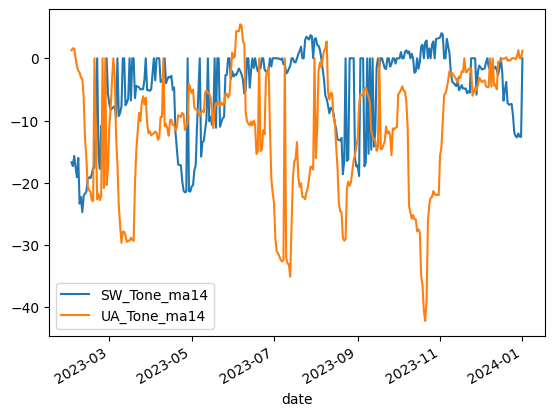

In [77]:

df_filtered[['SW_Tone_ma14','UA_Tone_ma14']].plot(legend=True)

In [38]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (2538,) and (8158,)

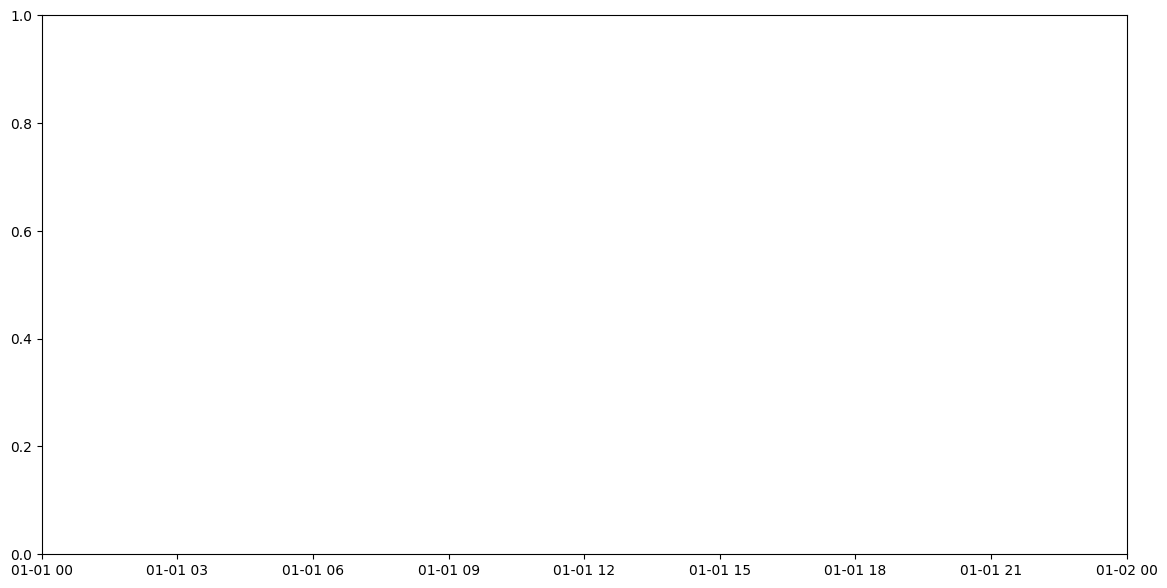

In [ ]:
# Line plot over time for 'American Airlines' and 'Southwest Airlines'

plt.figure(figsize=(14, 7))
plt.plot(df_AA['date'], df_agg_airlines['American Airlines'], label='American Airlines', marker='o')
plt.plot(df_SW['date'], df_agg_airlines['Southwest Airlines'], label='Southwest Airlines', marker='o')
plt.title('Number of Articles Mentioning Airlines Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()